# 1. Base64 to wav

**Goal**: **FROM** Transform base64 file (i.e. .txt format) **TO** Audio Format **.wav**

In [5]:
PATH = 'C:\\Users\\adsieg\\Desktop\\Speech\\PY_bac_sable\\TheVoice_adrien.txt'
NAME_OUTPUT_FILE = 'Output_voice_to_listen'

import base64
import io
import wave
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import IPython
import scipy
from scipy.io import wavfile

def transform_base64_to_audio(input_file, name_output_file):
    # 1. read txt file from base64
    with open(input_file, 'r') as f:
        input_base64 = base64.b64decode(f.read())
    
    # 2. Bytes-like objects 
    input_bytes = io.BytesIO(input_base64)
    
    # 3. Get my audio file
    audio_file = wave.open(input_bytes, 'rb')
    
    # 4. Get some information
    
    print(audio_file.getparams())
    print('''EXPLANATION : framerate is a frame rate which means each second of sound is represented by XXXX integers (integers because the file is in the common PCM 16-bit format). The file has a total of YYYY (=nframes) integers/frames, which means its length in seconds is: nframes/framerate''')
    
    # BONUS
    signal = audio_file.readframes(-1)
    signal = np.fromstring(signal, 'Int16')
    
    plt.figure(1)
    plt.title('Signal Wave...')
    plt.plot(signal)
    plt.show()

    fs = audio_file.getframerate()
    name_output_file = name_output_file+'.wav'
    wavfile.write(name_output_file,fs, signal)
    print('Your file is saved')
    
    return audio_file

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=696320, comptype='NONE', compname='not compressed')
EXPLANATION : framerate is a frame rate which means each second of sound is represented by XXXX integers (integers because the file is in the common PCM 16-bit format). The file has a total of YYYY (=nframes) integers/frames, which means its length in seconds is: nframes/framerate


C:\Users\adsieg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
C:\Users\adsieg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


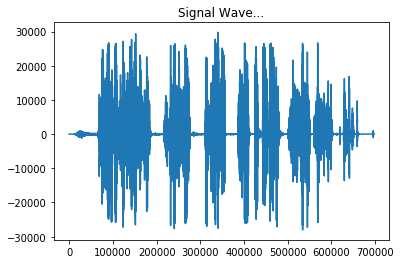

Your file is saved


In [6]:
# https://programming.rhysshea.com/Independent_component_analysis/
transform_base64_to_audio(PATH, NAME_OUTPUT_FILE)

# 2. Energy and RMSE

The **energy** of a signal corresponds to the **total magntiude of the signal**. For audio signals, that roughly corresponds to **how loud the signal is**. The energy in a signal is defined as: 

$\sum_n \left| x(n) \right|^2$

The root-mean-square energy (RMSE) in a signal is defined as

$\sqrt{ \frac{1}{N} \sum_n \left| x(n) \right|^2 }$

In [8]:
import IPython
IPython.display.Audio("Output_voice_to_listen.wav")

In [8]:
import librosa
import numpy 

x, sr = librosa.load('Output_voice_to_listen.wav')

In [3]:
sr

22050

In [4]:
x.shape

(319872,)

In [5]:
librosa.get_duration(x, sr)

14.506666666666666

In [9]:
hop_length = 256
frame_length = 512

energy = numpy.array([
    sum(abs(x[i:i+frame_length]**2))
    for i in range(0, len(x), hop_length)
])

energy.shape

(1250,)

In [10]:
rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)

In [11]:
rmse.shape

(1, 1250)

In [12]:
rmse = rmse[0]

In [13]:
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

# Fourier Transform

It transforms our **time-domain signal** into the **frequency domain**. Whereas the **time domain** expresses our signal as a **sequence of samples**, the **frequency domain** expresses our signal as a **superposition of sinusoids of varying magnitudes**, **frequencies**, and **phase offsets**.

In [19]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, librosa, IPython.display as ipd

In [20]:
import urllib

x, sr = librosa.load('Output_voice_to_listen.wav')

In [22]:
print('shape =',x.shape, 'sr = ', sr)

shape = (319872,) sr =  22050


In [23]:
ipd.Audio(x, rate=sr)

In [24]:
X = scipy.fft(x)
X_mag = numpy.absolute(X)
f = numpy.linspace(0, sr, len(X_mag)) # frequency variable

Text(0.5,0,'Frequency (Hz)')

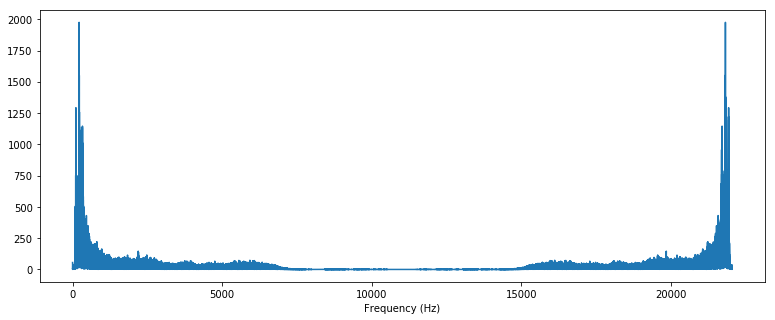

In [25]:
plt.figure(figsize=(13, 5))
plt.plot(f, X_mag) # magnitude spectrum
plt.xlabel('Frequency (Hz)')

Text(0.5,0,'Frequency (Hz)')

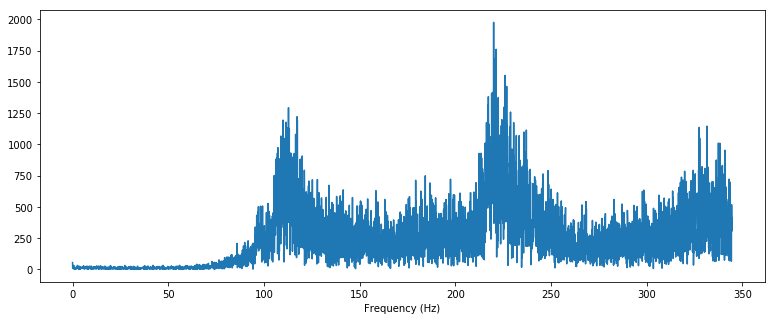

In [26]:
plt.figure(figsize=(13, 5))
plt.plot(f[:5000], X_mag[:5000])
plt.xlabel('Frequency (Hz)')

# MCFF feature extraction

https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

#### Load Data

In [47]:
import IPython
IPython.display.Audio("Output_voice_to_listen.wav")

In [48]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import sounddevice as sd
import IPython

sample_rate, signal = scipy.io.wavfile.read('Output_voice_to_listen.wav')  # File assumed to be in the same directory
signal = signal[0:int(20 * sample_rate)]  # Keep the first 20 seconds

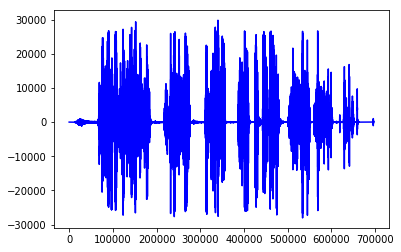

In [49]:
plt.plot(signal, c='b')
sd.play(signal)

#### Pre-Emphasis

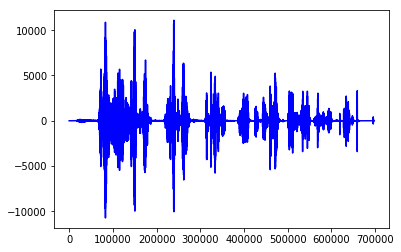

In [50]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

plt.plot(emphasized_signal, c='b')
sd.play(emphasized_signal)

#### Framing

In [51]:
# Split the signal into short-time frames
frame_size = 0.025
frame_stride = 0.01

# Convert from seconds to samples
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
# Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z)

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, 
                num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

#### Window

In [19]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

In [20]:
frames.shape

(1449, 1200)

#### Fourier-Transform and Power Spectrum

In [21]:
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

#### Filter Banks

In [62]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

#### Mel-frequency Cepstral Coefficients (MFCCs)

In [26]:
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

#### Mean Normalization

In [28]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

In [27]:
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)